In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.11.0
Hub version: 0.12.0
GPU is available


In [ ]:

model_handle_map = {
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",  
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2"
}

model_image_size_map = {
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,  
}

In [ ]:

model_name = "efficientnetv2-xl-21k"
model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)
print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")
BATCH_SIZE = 16

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


In [ ]:

data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
# build our dataset from https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
class_names_ = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()  # return number of dataset 

print(class_names)
print(train_size)

('daisy', 'dandelion', 'roses', 'sunflowers', 'tulips')
2936


In [ ]:
train_ds = train_ds.unbatch().batch(BATCH_SIZE) # ?
train_ds = train_ds.repeat() # ?

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = False

if do_data_augmentation:
  print("aug")
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

In [ ]:
train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels)) # ?

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

val_ds = val_ds.map(lambda images, labels: (normalization_layer(images), labels)) # ?

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# ?
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 6,405
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
print(IMAGE_SIZE + (3,))
print((None,)+IMAGE_SIZE+(3,))

(512, 512, 3)
(None, 512, 512, 3)


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
print(train_size // BATCH_SIZE)

183


In [ ]:
steps_per_epoch = train_size // BATCH_SIZE # ?
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(train_ds, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=val_ds, validation_steps=validation_steps).history

Epoch 1/5
183/183 [==============================] - 369s 2s/step - loss: 0.9390 - accuracy: 0.8890 - val_loss: 0.6999 - val_accuracy: 0.9403
Epoch 2/5
183/183 [==============================] - 294s 2s/step - loss: 0.6419 - accuracy: 0.9538 - val_loss: 0.6421 - val_accuracy: 0.9444
Epoch 3/5
183/183 [==============================] - 317s 2s/step - loss: 0.6011 - accuracy: 0.9596 - val_loss: 0.5915 - val_accuracy: 0.9542
Epoch 4/5
183/183 [==============================] - 317s 2s/step - loss: 0.5770 - accuracy: 0.9647 - val_loss: 0.6180 - val_accuracy: 0.9597
Epoch 5/5
183/183 [==============================] - 317s 2s/step - loss: 0.5504 - accuracy: 0.9736 - val_loss: 0.5824 - val_accuracy: 0.9583


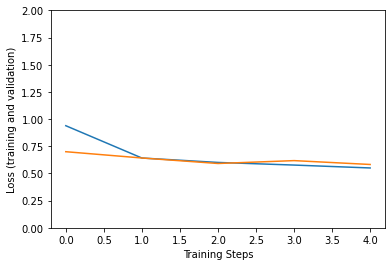

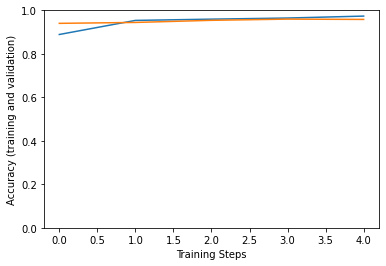

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

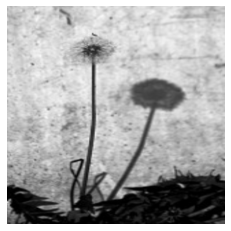

1/1 [==============================] - 0s 117ms/step
True label: dandelion
Predicted label: dandelion
prediction_scores   [[-1.427498    1.4179924   0.21243337 -0.95072824 -1.3619896 ]]


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label because image shape is TensorShape([512, 512, 3])
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)

print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])
print("prediction_scores  ", prediction_scores)
     

In [ ]:
np.argmax(y[0])

1

In [ ]:
image.shape

TensorShape([512, 512, 3])

In [ ]:
dataset = tf.data.Dataset.range(5)
print(tf.data.experimental.cardinality(dataset).numpy())
for element in dataset:
  print(element)

dataset = dataset.repeat(3)  

for element in dataset:
  print(element)

5
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
